In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_columns', 100)

from utils.utils import *

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

In [2]:
%%time
hemato = make_all_dataset(force_download='no')

Optimizing df...

Original df size: Total memory usage: 1530.61 MB
Optimized df size: Total memory usage: 154.20 MB
CPU times: user 27.9 s, sys: 2.66 s, total: 30.5 s
Wall time: 23.5 s


In [3]:
hemato.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 841112 entries, 24 to 7544
Data columns (total 52 columns):
UF_ZI             841112 non-null category
ANO_CMPT          841112 non-null category
MES_CMPT          841112 non-null category
N_AIH             841112 non-null object
MUNIC_RES         841112 non-null category
NASC              841112 non-null category
SEXO              841112 non-null category
UTI_MES_TO        841112 non-null uint8
UTI_INT_TO        841112 non-null uint8
DIAR_ACOM         841112 non-null uint8
QT_DIARIAS        841112 non-null int64
VAL_SH            841112 non-null float32
VAL_SP            841112 non-null float32
VAL_SADT          841112 non-null float32
VAL_ACOMP         841112 non-null float32
VAL_SANGUE        841112 non-null float32
VAL_TOT           841112 non-null float32
VAL_UTI           841112 non-null float32
US_TOT            841112 non-null float32
DT_INTER          841112 non-null datetime64[ns]
DT_SAIDA          841112 non-null datetime64[n

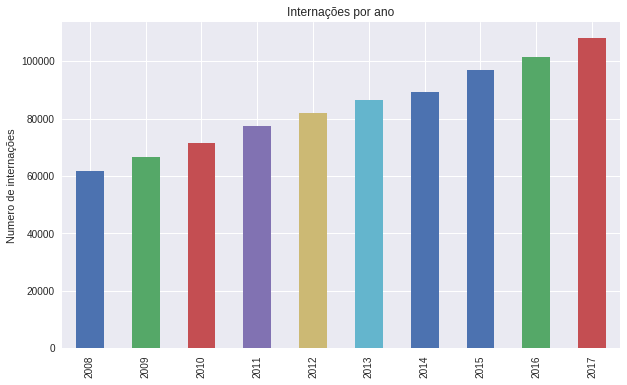

In [4]:
# internações por ano:

hemato.ANO_CMPT.value_counts().sort_index().plot(kind='bar', title='Internações por ano', figsize=(10, 6))
plt.ylabel('Numero de internações')
plt.show()

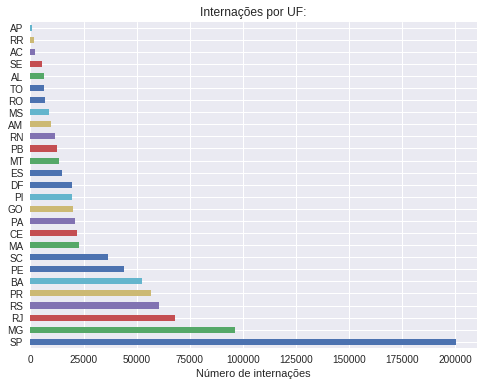

In [5]:
hemato.UF.value_counts().plot(kind='barh', figsize=(8, 6))
plt.title('Internações por UF:')
plt.xlabel('Número de internações')
plt.show()

In [6]:
import wget
import os
from utils import PRODUCED_DATASETS
from zipfile import ZipFile


def download_TAB_SIH_zip(force_download=False):
    '''
    Download TAB_SIH.zip and save in cache.
    
    Returns
    -------
        local path to the downloaded file
    '''
    URL = 'ftp://ftp.datasus.gov.br/dissemin/publicos/SIHSUS/200801_/Auxiliar/TAB_SIH.zip'
    filename = wget.detect_filename(URL)
    local_file = os.path.join(PRODUCED_DATASETS, filename)
    if not os.path.exists(local_file) or force_download:
        wget.download(url, localfile)
    return local_file
        

def make_maps(local_zipfile='/home/gui/tcc_hemato_sus/produced_datasets/TAB_SIH.zip'):
    download_TAB_SIH_zip()
    with ZipFile(local_zipfile) as zfile:
        with zfile.open('SEXO.CNV') as sex_file:
            df = pd.read_table(sex_file, sep=b'\s{2,}', engine='python',
                               skiprows=1, header=None).applymap(func_decode)
            sex_map = {df.loc[0, 2][0]: df.loc[0, 1],
                       df.loc[0, 2][2]: df.loc[0, 1],
                       df.loc[1, 2]:    df.loc[1, 1],
                       df.loc[2, 2][0]: df.loc[2, 1],
                       df.loc[2, 2][2]: df.loc[2, 1]}
#             print(df)
            return sex_map

def func_decode(x):
    if type(x) == bytes:
        return x.decode()

In [7]:
sex_map = make_maps()

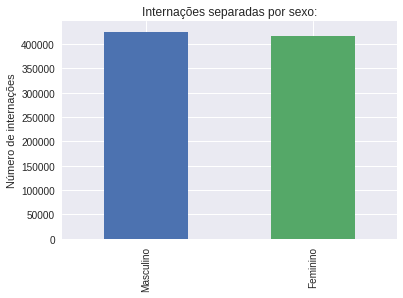

In [8]:
# internações por sexo

hemato.SEXO.map(sex_map).value_counts().plot(kind='bar')
plt.title('Internações separadas por sexo:')
plt.ylabel('Número de internações')
plt.show()

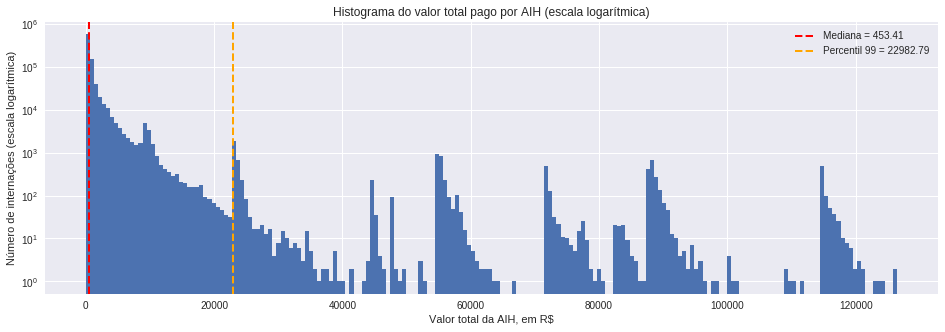

In [9]:
# valor total recebido por AIH
# a escala é logarítmica por causa da amplitude dos valores

hemato.VAL_TOT.hist(log=True, bins=200, figsize=(16, 5))
median = hemato.VAL_TOT.quantile(.5)
p = hemato.VAL_TOT.quantile(.99)
plt.axvline(x=median, color='r', linestyle='--', linewidth=2, label='Mediana = {:.2f}'.format(median))
plt.axvline(x=p, color='orange', linestyle='--', linewidth=2, label='Percentil 99 = {:.2f}'.format(p))

plt.xlabel('Valor total da AIH, em R$')
plt.ylabel('Número de internações (escala logarítmica)')
plt.legend(loc=1)
plt.title('Histograma do valor total pago por AIH (escala logarítmica)')
plt.show()

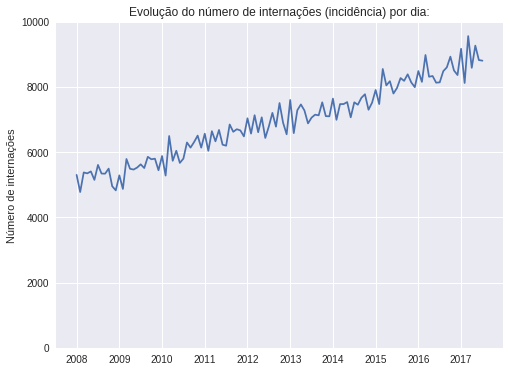

In [10]:
int_by_day = pd.to_datetime(hemato.DT_INTER).value_counts()
# claramente aumentou o número absoluto
# parece que as vezes a velocidade de crescimento diminui um pouco no inverno com picos em fevereiro (?)
# TODO: ver a população a cada ano e ver se aumentou o percentual de internações hemato

int_by_day['2008':'2017'].resample('M').sum()[:-5].plot(figsize=(8, 6),
                                                        ylim=(0, 10000))
plt.title('Evolução do número de internações (incidência) por dia:')
plt.ylabel('Número de internações')
plt.show()

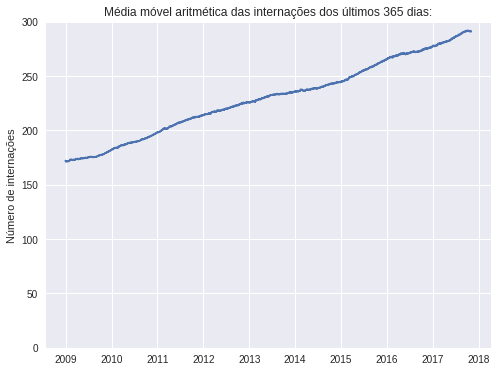

(cada ponto é a média das internações dos últimos 365 dias)


In [11]:
int_by_day['2008':'2017'].resample('D').sum().rolling(365).mean()[:-60].plot(figsize=(8, 6),
                                                                             ylim=(0, 300))
plt.title('Média móvel aritmética das internações dos últimos 365 dias:')
plt.ylabel('Número de internações')
plt.show()
print('(cada ponto é a média das internações dos últimos 365 dias)')

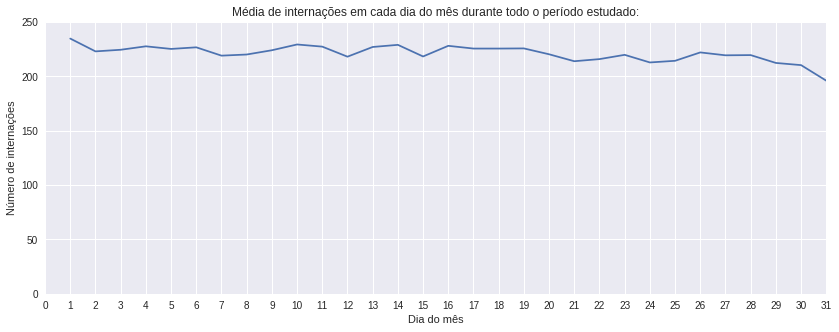

In [12]:
# media de internações por dia do mês

int_by_day.groupby(int_by_day.index.day).mean().plot(figsize=(14, 5), xlim=(0, 31), ylim=(0,250),
                                                     xticks=(np.arange(32))) 
plt.title('Média de internações em cada dia do mês durante todo o período estudado:')
plt.ylabel('Número de internações')
plt.xlabel('Dia do mês')
plt.show()

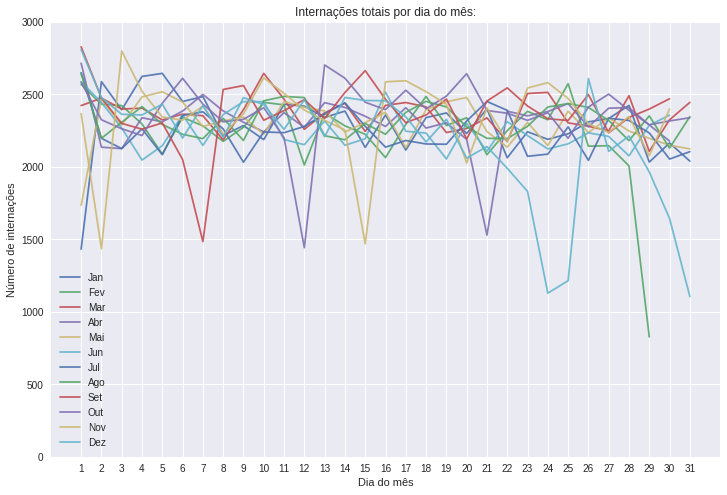

In [13]:
make_daily_int_each_month(hemato)

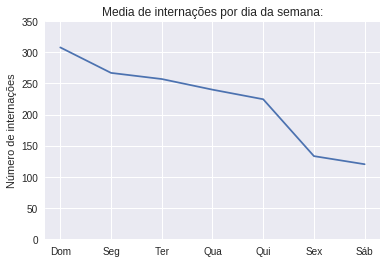

In [14]:
# TODO: fazer bootstrap para ver significância, fazer prevalência

int_by_day.groupby(int_by_day.index.weekday).mean().plot(ylim=(0,350))
plt.xticks(np.arange(7), ['Dom', 'Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb'])
plt.title('Media de internações por dia da semana:')
plt.ylabel('Número de internações')
plt.show()

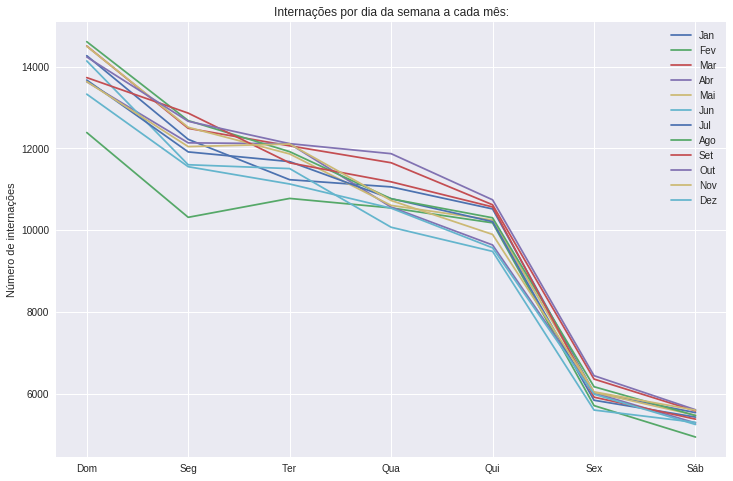

Parece que não muda muito o padrão.


In [15]:
make_weekly_graph(hemato)

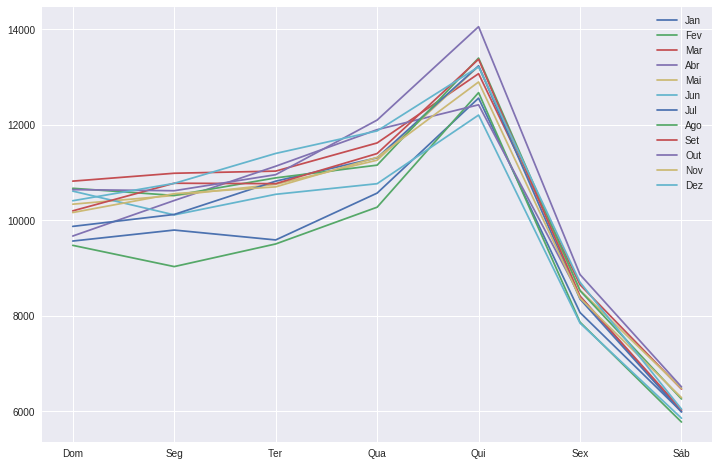

In [16]:
# Altas por dia da semana, em cada mês
# (planejamento de plantões/sobreavisos)
# não é a prevalência, é o número de novas internações (incidência)

pivoted = hemato.pivot_table('N_AIH', index=hemato.DT_SAIDA.dt.weekday, columns=hemato.DT_SAIDA.dt.month,
                             aggfunc='count')

pivoted.columns.name = None
pivoted.columns = months
pivoted.index.name = None

pivoted.plot(figsize=(12, 8), legend=True)
plt.xticks(np.arange(7), ['Dom', 'Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb'])
plt.show()

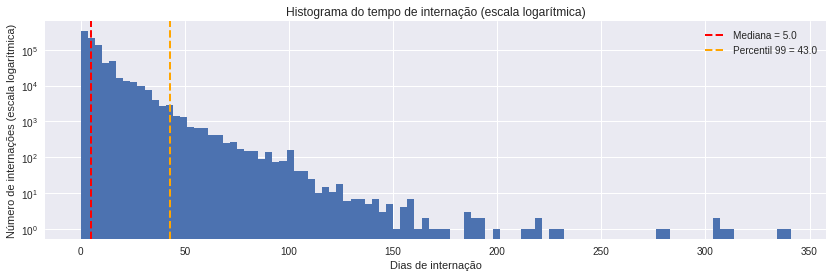

In [17]:
# tempo de internação

hemato.DIAS_PERM.hist(bins=100, log=True, figsize=(14, 4))
median = hemato.DIAS_PERM.quantile(.5)
p = hemato.DIAS_PERM.quantile(.99)
plt.axvline(x=median, color='r', linestyle='--', linewidth=2, label='Mediana = {}'.format(median))
plt.axvline(x=p, color='orange', linestyle='--', linewidth=2, label='Percentil 99 = {}'.format(p))

plt.xlabel('Dias de internação')
plt.ylabel('Número de internações (escala logarítmica)')
plt.legend(loc=1)
plt.title('Histograma do tempo de internação (escala logarítmica)')
plt.show()

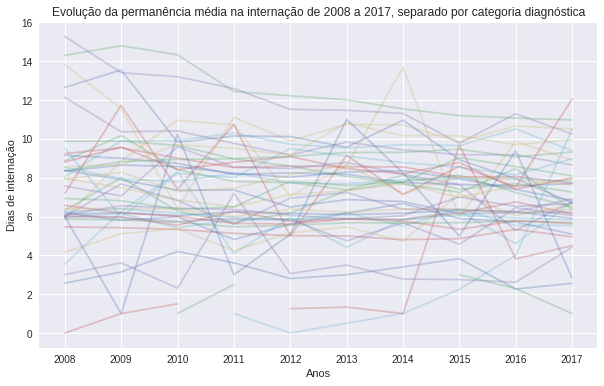

In [18]:
pivoted = hemato.pivot_table('DIAS_PERM', columns='DIAG_PRINC_CAT', index='ANO_CMPT', aggfunc='mean')

pivoted.plot(alpha=.3, legend=False, figsize=(10, 6))
plt.xlabel('Anos')
plt.xticks(np.arange(10), pivoted.index)
plt.title('Evolução da permanência média na internação de 2008 a 2017, separado por categoria diagnóstica')
plt.ylabel('Dias de internação')
plt.show()

## Todo:

X DIAG_PRINC separar CIDs de hemato antes de juntar os arquivos.

X Por que o N_AIH tem numeros repetidos? Interna várias vezes com o mesmo registro? Erro?

Identificar a cidade pelo CEP e verificar quem tem um endereço e interna em outra cidade/estado.

Posso usar o MUNIC_RES pra fazer o que escrevi acima.

UTI_MES_TO e UTI_INT_TO pode dizer quais CIDs são mais graves. Se o percentual de internações graves aumentou. Posso relacionar se morrem muito na UTI ou se salvam muito.

Hemato ganha muita diaria de acompanhante? DIAR_ACOM

Quais CIDs ficam mais tempo internado? QT_DIARIAS Algum estado demora mais no tratamento, comparando mesmas doenças? Isso se reflete no resultado do tto?

----------
##### Financeiro

VAL_SH (hosp) VAL_SP (profissional) VAL_TOT VAL_UTI US_TOT Quanto paga cada internação de hemato? Qual paga mais?

FINANC A grana vem de onde?

VAL_SADT, VAL_ACOMP, VAL_SANGUE está zerado???

90 VAL_SH_FED numeric (10, 2) Valor do complemento federal de serviços hospitalares. Está
 incluído no valor total da AIH.

91 VAL_SP_FED numeric (10, 2) Valor do complemento federal de serviços profissionais. Está
 incluído no valor total da AIH.

92 VAL_SH_GES numeric (10, 2) Valor do complemento do gestor (estadual ou municipal) de
 serviços hospitalares. Está incluído no valor total da AIH.

93 VAL_SP_GES numeric (10, 2) Valor do complemento do gestor (estadual ou municipal) de
 serviços profissionais. Está incluído no valor total da AIH.
 
VAL_UCI O que é UCI???

-----------

DT_INTER DT_SAIDA DIAS_PERM Datas de int e alta conferem com as diárias? Há datas de anos/meses anteriores que contaram nesta competencia (atraso de envio?)

Não incluí a natureza jurídica e a gestão porque é certo que vai ter mais internações nos tipos de lugares que existem, seja por imposição legal ou incentivo fiscal. Não quer dizer que sejam mais importantes.

MUNIC_MOV Municipio do estabelecimento. Este dado é confiável? Se for, posso usar pra comparar com o MUNIC_RES.

COD_IDADE IDADE Perfil de idade dos pacientes atendidos.

NACIONAL Nacionalidade do paciente

CAR_INT Vem muito pct hemato de emergência?

CBOR NUM_FILHOS INSTRU VINCPREV Acho importante pra comparar por regiões e por tempo, mas tenho dúvidas da veracidade dos dados.

RACA_COR ETNIA Comparar as duas classificações.

Qual a prevalência de pacientes internados? (Como calcular a prevalencia?)